In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import os

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

# Loading enhanced data
try:
    df = pd.read_csv('../data/processed/delhi_aqi_enhanced.csv', index_col='Date', parse_dates=True)
    print("Enhanced Delhi data loaded successfully.")
except FileNotFoundError:
    print("Error: delhi_aqi_enhanced.csv not found. Please run the EDA notebook first.")

# Feature Engineering 
for i in range(1, 8):
    df[f'AQI_lag_{i}'] = df['AQI'].shift(i)
df['AQI_rolling_mean_7'] = df['AQI'].shift(1).rolling(window=7).mean()
df.dropna(inplace=True)

# Defining Features (X) and Target (y) 
features = [f'AQI_lag_{i}' for i in range(1, 8)] + ['AQI_rolling_mean_7']
X = df[features]
y = df['AQI']

# Data Splitting
split_point = int(len(df) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]



Enhanced Delhi data loaded successfully.


In [2]:
# --- Model Training and Evaluation ---
# We will store results in a dictionary for easy comparison later.
model_performance = {}

# Model 1: Linear Regression 
print("\n--- Training Model 1: Linear Regression ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_r2 = r2_score(y_test, lr_predictions)
model_performance['Linear Regression'] = {'RMSE': lr_rmse, 'R2': lr_r2}
print(f"Linear Regression RMSE: {lr_rmse:.4f}, R²: {lr_r2:.4f}")

# Model 2: Lasso Regression
print("\n--- Training Model 2: Lasso Regression ---")
# Justification: Lasso (L1 regularization) can shrink some feature coefficients to zero,
# effectively performing automatic feature selection. This is useful to see if a simpler
# model with fewer features can perform well or not.
lasso_model = Lasso(alpha=1.0, random_state=42) # the regularization strength is alpha
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_predictions))
lasso_r2 = r2_score(y_test, lasso_predictions)
model_performance['Lasso Regression'] = {'RMSE': lasso_rmse, 'R2': lasso_r2}
print(f"Lasso Regression RMSE: {lasso_rmse:.4f}, R²: {lasso_r2:.4f}")

# Model 3: A bit Advanced - XGBoost Regressor
print("\n--- Training Model 3: XGBoost ---")
features_tree = features + ['Year', 'Month']
X_train_tree = df[features_tree][:split_point]
X_test_tree = df[features_tree][split_point:]

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
                             max_depth=5, early_stopping_rounds=50, random_state=42)
eval_set = [(X_test_tree, y_test)]
xgb_model.fit(X_train_tree, y_train, eval_set=eval_set, verbose=False)
xgb_predictions = xgb_model.predict(X_test_tree)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)
model_performance['XGBoost'] = {'RMSE': xgb_rmse, 'R2': xgb_r2}
print(f"XGBoost RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")

# Model 4: Advanced - LightGBM Regressor
print("\n--- Training Model 4: LightGBM ---")
# Justification: LightGBM is another high-performance gradient boosting framework. It often trains
# faster than XGBoost and is a strong alternative. Comparing them in a approach that is robust.
lgbm_model = lgb.LGBMRegressor(objective='regression', n_estimators=1000, learning_rate=0.05,
                               max_depth=5, random_state=42)
lgbm_model.fit(X_train_tree, y_train,
               eval_set=[(X_test_tree, y_test)],
               eval_metric='rmse',
               callbacks=[lgb.early_stopping(50, verbose=False)])
lgbm_predictions = lgbm_model.predict(X_test_tree)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_predictions))
lgbm_r2 = r2_score(y_test, lgbm_predictions)
model_performance['LightGBM'] = {'RMSE': lgbm_rmse, 'R2': lgbm_r2}
print(f"LightGBM RMSE: {lgbm_rmse:.4f}, R²: {lgbm_r2:.4f}")


--- Training Model 1: Linear Regression ---
Linear Regression RMSE: 43.8346, R²: 0.8510

--- Training Model 2: Lasso Regression ---
Lasso Regression RMSE: 43.8373, R²: 0.8509

--- Training Model 3: XGBoost ---
XGBoost RMSE: 43.3035, R²: 0.8545

--- Training Model 4: LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 1601, number of used features: 10
[LightGBM] [Info] Start training from score 272.904435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [3]:
# Model Comparison Summary
print("\n--- Model Performance Summary ---")
performance_df = pd.DataFrame(model_performance).T
performance_df.sort_values(by='RMSE', ascending=True, inplace=True)
print(performance_df)

# Saving the performance to a CSV file for the report
performance_df.to_csv('../reports/model_performance_summary.csv')


--- Model Performance Summary ---
                        RMSE        R2
XGBoost            43.303520  0.854547
LightGBM           43.796263  0.851218
Linear Regression  43.834604  0.850957
Lasso Regression   43.837278  0.850939



--- Visualizing Best Model Performance ---


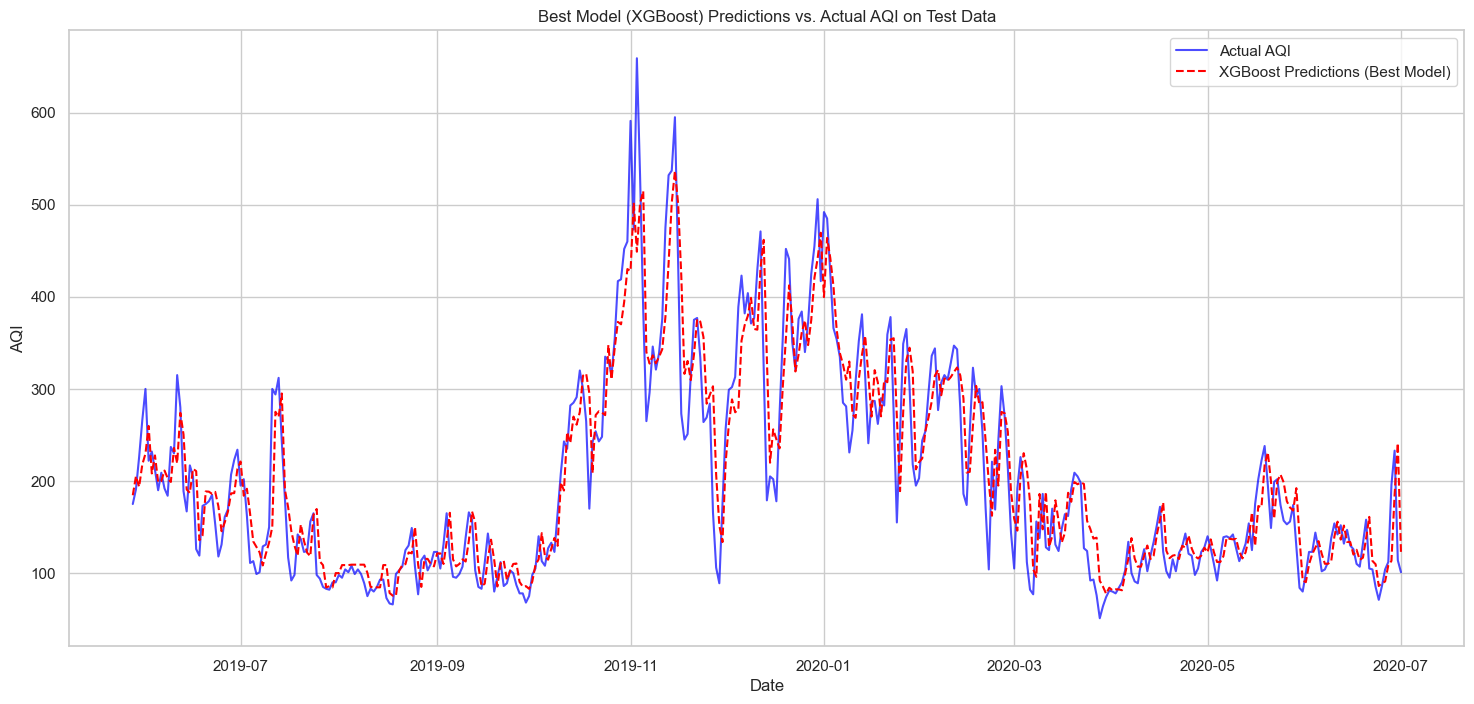


--- Feature Importance of Best Model ---


<Figure size 1000x600 with 0 Axes>

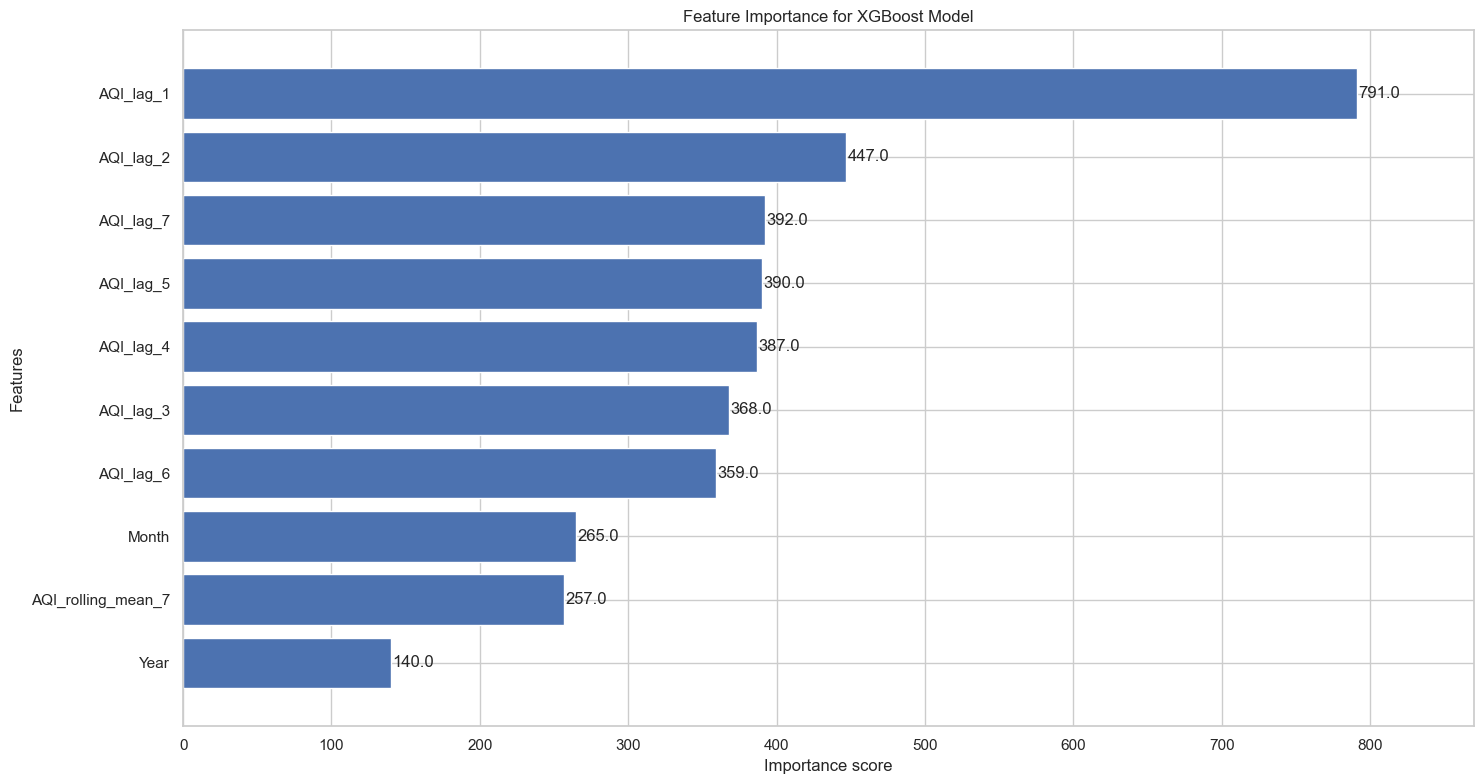

In [4]:
#Visualizing Results (Comparision)
print("\n--- Visualizing Best Model Performance ---")
plt.figure(figsize=(18, 8))
plt.plot(y_test.index, y_test, label='Actual AQI', color='blue', alpha=0.7)
plt.plot(y_test.index, xgb_predictions, label='XGBoost Predictions (Best Model)', color='red', linestyle='--')
plt.title('Best Model (XGBoost) Predictions vs. Actual AQI on Test Data')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.savefig('../reports/figures/best_model_predictions_vs_actual.png')
plt.show()

# Feature Importance from Best Model (XGBoost)
# (Assuming XGBoost is the best, which is likely. If not, this can be adapted.)
print("\n--- Feature Importance of Best Model ---")
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, height=0.8)
plt.title('Feature Importance for XGBoost Model')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png')
plt.show()